# 0. Setup

In [1]:
# Import Packages
import numpy as np
import pandana as pdna
import geopandas as gpd
import pandas as pd
import shapely
from shapely import wkt
import statistics
import matplotlib.pyplot as plt
import zipfile

# Import sklearn modelling packages
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# Import performance metrics
from sklearn.metrics import (mean_absolute_error as mae, mean_squared_error as mse, 
                             explained_variance_score as evs, r2_score as r2)                # Regression
from sklearn.metrics import (accuracy_score as acc, balanced_accuracy_score as bal_acc, 
                             f1_score as f1, roc_auc_score as roc_auc,
                             average_precision_score as ave_prec)                            # Classification
def mape(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

In [2]:
# Ignore Warnings
import warnings

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Assumptions
rs=42

sd_thresh = 1

# 1. Import and split data

## 1.1 Import

In [39]:
# Import Modelling Data
data_11 = pd.read_csv('C:\\Users\\wthac\\Desktop\\Value Australia\\Data\\ML Gentrification Prediction\\Inputs\\Cleaned Dataset/Data_11_SEIFA_FINAL_GH.csv')
data_16 = pd.read_csv('C:\\Users\\wthac\\Desktop\\Value Australia\\Data\\ML Gentrification Prediction\\Inputs\\Cleaned Dataset/Data_16_SEIFA_FINAL_GH.csv')

# Import Data to be used for model explanation:
# 2011 and 2016 combined full dataset - to be used in SHAPley explanations
data_comb = pd.read_csv('C:\\Users\\wthac\\Desktop\\Value Australia\\Data\\ML Gentrification Prediction\\Inputs\\Cleaned Dataset/Data_comb_SEIFA_final_MATT.csv')

data_comb = data_comb.dropna()

## 1.2 Data split (80/20 ratio)

In [5]:
# Split data into training/test/validation
train, test = train_test_split(data_11, test_size = 0.2, random_state = rs)

# Split into X and Y
x_train = train.iloc[:,2:-14]  # Not including walkability metrics
y_train = train.iloc[:,-1]

x_test = test.iloc[:,2:-14]  # Not including walkability metrics
y_test = test.iloc[:,-1]

# 2. Build untuned GBM model

## 2.1 Fit basic GBM

In [6]:
# Import necessary packages
gbm = GradientBoostingRegressor(random_state=42)

In [7]:
# Fit basic RF model
gbm_model = gbm.fit(x_train, y_train)

# Fit prediction to test dataset
y_pred_gbm = gbm_model.predict(x_test)

## 2.2 Evaluate Performance - Based on SEIFA Score

In [43]:
# Calculate metrics
mae_gbm = mae(y_test, y_pred_gbm)
mse_gbm = mse(y_test, y_pred_gbm)
evs_gbm = evs(y_test, y_pred_gbm)
r2_gbm = r2(y_test, y_pred_gbm)
mape_gbm = mape(y_test, y_pred_gbm)

print(f"mae_gbm: {mae_gbm}, \nmse_gbm: {mse_gbm}, \nevs_gbm: {evs_gbm}, \nr2_gbm: {r2_gbm}, \nmape_gbm: {mape_gbm}")

mae_gbm: 18.519085830985, 
mse_gbm: 824.1378234823748, 
evs_gbm: 0.92421234237, 
r2_gbm: 0.92421234237, 
mape_gbm: 2.07028316218


## 2.3 Calculate predicted change in rank based on SEIFA score

In [9]:
# Create new dataset to store results
test_gbm = test

## Actual Rank Change
# Calculate the rank of each irsad_score within year
seq_11 = sorted(test_gbm['irsad_score_11'])
index_11 = [seq_11.index(v) for v in test_gbm['irsad_score_11']]

seq_16 = sorted(test_gbm['irsad_score_16'])
index_16 = [seq_16.index(v) for v in test_gbm['irsad_score_16']]

# Merge rank back onto main dataset
test_gbm['SEIFA_rank_11'] = index_11
test_gbm['SEIFA_rank_16'] = index_16

# Calculate change in rank:
test_gbm['SEIFA_rc_actual'] = test_gbm['SEIFA_rank_16'] - test_gbm['SEIFA_rank_11']


## Untuned GBM Predicted Rank Change
test_gbm['SEIFA_16_gbm'] = y_pred_gbm
seq_16_gbm = sorted(test_gbm['SEIFA_16_gbm'])
index_16_gbm = [seq_16_gbm.index(v) for v in test_gbm['SEIFA_16_gbm']]

# Merge rank back onto main dataset
test_gbm['SEIFA_rank_16_gbm'] = index_16_gbm

# Calculate change in rank:
test_gbm['SEIFA_rc_gbm'] = test_gbm['SEIFA_rank_16_gbm'] - test_gbm['SEIFA_rank_11']

## 2.4 Evaluate Performance - Based on Gentrification Flag

### 2.4.1 Gentrification Flag

SA1 area's are considered *gentrifying* if the [socioeconomic] rank change of the SA1 area is greater than 1 standard deviation of rank change. 

For example, take a Marrickville SA1 that had a SEIFA score of 1020 in 2011 which corresponded to a rank of 6000 out of 10,000 for Sydney in 2011. In 2016, the predicted SEIFA score is 1080, which increase the SA1's rank to 8000 out of 10,000. 

The standard deviation of rank change between 2011 - 2016 is 1000, so given that the Marrickville SA1's rank change is 2000 (> 1 Standard Deviation), it is considered *gentrifying*.

To evaluate the performance of the model in classifying neighbourhoods as gentrifying, I use classification model performance metrics.

In [10]:
# Calculate standard deviation of rank change
sd_rc = statistics.stdev(test_gbm['SEIFA_rc_actual'])
sd_rc_gbm = statistics.stdev(test_gbm['SEIFA_rc_gbm'])

# Create new column flagging gentrification
test_gbm['gentrification_flag'] = np.where(test_gbm['SEIFA_rc_actual'] > sd_thresh * sd_rc, 1, 0)
test_gbm['gentrification_flag_gbm'] = np.where(test_gbm['SEIFA_rc_gbm'] > sd_thresh * sd_rc_gbm, 1, 0)

In [44]:
# Define actual and predicted vectors
gent_test = test_gbm['gentrification_flag']
gent_pred_gbm = test_gbm['gentrification_flag_gbm']

# Calculate classification pegbmormance scores
acc_gbm_gent = acc(gent_test, gent_pred_gbm)
bal_acc_gbm_gent = bal_acc(gent_test, gent_pred_gbm)
f1_gbm_gent = f1(gent_test, gent_pred_gbm)
roc_auc_gbm_gent = roc_auc(gent_test, gent_pred_gbm)
ave_prec_gbm_gent = ave_prec(gent_test, gent_pred_gbm)

print(f"acc_gbm_gent: {acc_gbm_gent}, \nbal_acc_gbm_gent: {bal_acc_gbm_gent}, \nf1_gbm_gent: {f1_gbm_gent}, \
      \nroc_auc_gbm_gent: {roc_auc_gbm_gent}, \nave_prec_gbm_gent: {ave_prec_gbm_gent}")

acc_gbm_gent: 0.8590572498279, 
bal_acc_gbm_gent: 0.720441249278923, 
f1_gbm_gent: 0.497328957349,       
roc_auc_gbm_gent: 0.720441249278923, 
ave_prec_gbm_gent: 0.309772384738


# 3. Hyperparameter tuning

Now I will be performing the hyperparameter tuning of the GBM model. The hyperparameters that I will tune include:

Tree-Based Parameters:

- max_features
- max_depth
- min_samples_split
- min_samples_leaf

Boosting Parameters:

- n_estimators
- learning rate
- subsample

I will take the following general approach to tuning:

1. Choose a relatively high learning rate. Generally the default value of 0.1 works - this will be changed later in the process, because generally speaking a lower learning rate will always improve the model (given sufficient trees), however will make the calculations more computationally expensive
2. Determine the optimum number of trees for this learning rate, after fixing some of the tree-based parameters.
3. Tune tree-specific parameters for decided learning rate and number of trees. Note that we can choose different parameters to define a tree.
4. Tune subsample and lower the learning rate and increase the estimators proportionally to get more robust models.

## 3.1 Tune optimum number of estimators using GridSearchCV()

In order to tune optimum number of trees, we need to first fix the learning rate and tree-based parameters. Therefore, I will fix:

- Learning rate = 0.15 ---- NOTE: Initially chose 0.1, however tuned n_estimators was very high - meaning tuning other paramaters would be too timely, therefore increase learning rate for now, and will lower learning rate later
- subsample = 0.8
- min_samples_split = 5
- min_samples_leaf = 4
- max_features = 20
- max_depth = 8

In [12]:
# Define n_estimators space:
n_estimators = np.arange(20, 101, 10)

# Define fixed starting parameters
lr_t1 = 0.15
ss_t1 = 0.8
mss_t1 = 5
msl_tl = 4
mf_t1 = 20
md_t1 = 8

# Create parameter grid
param_grid_t1 = dict(n_estimators = n_estimators)

# Create GBM model with fixed starting parameters
gbm_t1 = GradientBoostingRegressor(learning_rate = lr_t1, min_samples_split = mss_t1, min_samples_leaf = msl_tl,
                                   max_depth = md_t1, max_features=mf_t1, subsample=ss_t1, random_state=rs)

grid_t1=GridSearchCV(estimator=gbm_t1, param_grid=param_grid_t1, cv=5)

In [13]:
grid_t1.fit(x_train, y_train)

print("The best n_estimators is %s with a score of %0.4f"
     % (grid_t1.best_params_, grid_t1.best_score_))

The best n_estimators is {'n_estimators': 40} with a score of 0.9284


## 3.2 Tune tree-specific parameters

The next steps is to choose the tree-based parameters using the decided n_estimators and learning_rate. I will tune the parameters separately so as to reduce calculation time.

### 3.2.1 Tune max_depth and min_samples_split simultaneously

In [14]:
# Define max_depth and min_samples_split space:
max_depth = np.arange(5, 16, 2)
min_samples_split = np.arange(3, 5, 10)

# Define fixed starting parameters
ne_t2 = 60

lr_t2 = 0.15
ss_t2 = 0.8
msl_t2 = 4
mf_t2 = 20

# Create parameter grid
param_grid_t2 = dict(max_depth = max_depth, 
                     min_samples_split = min_samples_split)

# Create GBM model with fixed starting parameters
gbm_t2 = GradientBoostingRegressor(learning_rate = lr_t2, n_estimators = ne_t2, min_samples_leaf = msl_tl,
                                   max_features=mf_t2, subsample=ss_t2, random_state=rs)

grid_t2=GridSearchCV(estimator=gbm_t2, param_grid=param_grid_t2, cv=5)

In [15]:
grid_t2.fit(x_train, y_train)

print("The best parameters are %s with a score of %0.4f"
     % (grid_t2.best_params_, grid_t2.best_score_))

The best parameters are {'max_depth': 7, 'min_samples_split': 3} with a score of 0.9303


### 3.2.2 Tune min_samples_leaf

In [16]:
# Define max_depth and min_samples_split space:
min_samples_leaf = np.arange(2, 15, 2)

# Define fixed starting parameters
ne_t3 = 60
md_t3 = 9
mss_t3 = 3

lr_t3 = 0.15
ss_t3 = 0.8
mf_t3 = 20

# Create parameter grid
param_grid_t3 = dict(min_samples_leaf = min_samples_leaf)

# Create GBM model with fixed starting parameters
gbm_t3 = GradientBoostingRegressor(learning_rate = lr_t3, n_estimators = ne_t3, min_samples_split = mss_t3, 
                                   max_depth = md_t3, max_features=mf_t3, subsample=ss_t3, random_state=rs)

grid_t3=GridSearchCV(estimator=gbm_t3, param_grid=param_grid_t3, cv=5)

In [17]:
grid_t3.fit(x_train, y_train)

print("The best min_samples_leaf is %s with a score of %0.4f"
     % (grid_t3.best_params_, grid_t3.best_score_))

The best min_samples_leaf is {'min_samples_leaf': 14} with a score of 0.9301


### 3.2.3 Tune max_features

In [18]:
# Define max_depth and min_samples_split space:
max_features = np.arange(10, 51, 5)

# Define fixed starting parameters
ne_t4 = 60
md_t4 = 9
mss_t4 = 3
msl_t4 = 12

lr_t4 = 0.15
ss_t4 = 0.8

# Create parameter grid
param_grid_t4 = dict(max_features = max_features)

# Create GBM model with fixed starting parameters
gbm_t4 = GradientBoostingRegressor(learning_rate = lr_t4, n_estimators = ne_t4, min_samples_split = mss_t4, 
                                   max_depth = md_t4, min_samples_leaf=msl_t4, subsample=ss_t4, random_state=rs)

grid_t4=GridSearchCV(estimator=gbm_t4, param_grid=param_grid_t4, cv=5)

In [19]:
grid_t4.fit(x_train, y_train)

print("The best max_features is %s with a score of %0.4f"
     % (grid_t4.best_params_, grid_t4.best_score_))

The best max_features is {'max_features': 25} with a score of 0.9302


## 3.3 Tuning boosting parameters

### 3.3.1 Tuning subsample

Next, I will test different subsample values. The subsample represents the fractions of observations to be selected for each tree; selection is done by random sampling. Values slightly less than 1 make the model robust by reducing the variance. 

I will test values around the starting value of ~0.8..

In [20]:
# Define max_depth and min_samples_split space:
subsample = [0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

# Define fixed starting parameters
ne_t5 = 60
md_t5 = 9
mss_t5 = 3
msl_t5 = 12
mf_t5 = 30

lr_t5 = 0.15

# Create parameter grid
param_grid_t5 = dict(subsample = subsample)

# Create GBM model with fixed starting parameters
gbm_t5 = GradientBoostingRegressor(learning_rate = lr_t5, n_estimators = ne_t5, min_samples_split = mss_t5, 
                                   max_depth = md_t5, min_samples_leaf=msl_t5, max_features=mf_t5, random_state=rs)

grid_t5=GridSearchCV(estimator=gbm_t5, param_grid=param_grid_t5, cv=5)

In [21]:
grid_t5.fit(x_train, y_train)

print("The best subsample is %s with a score of %0.4f"
     % (grid_t5.best_params_, grid_t5.best_score_))

The best subsample is {'subsample': 0.9} with a score of 0.9299


### 3.3.2 Making models with lower learning rate

Now, we need to lower the learning rate and increase the number of estimators proportionally. 
I have taken the general approach of *halving* the learning rate and *doubling* the number of trees in each case.

As trees increase, it will become increasingly computationally expensive to perform CV and find the optimum values. 

In [22]:
# Define tuned hyperparameters
ne_tuned = 60
ss_tuned = 0.85 

md_tuned = 9
mss_tuned = 3
msl_tuned = 12
mf_tuned = 30

Reduce learning rate to **0.1** and increase n_estimators to **90**

In [23]:
# Define GBM model
gbm_tuned_lr1 = GradientBoostingRegressor(learning_rate = 0.1, n_estimators=90,
                                          max_depth = md_tuned, min_samples_split = mss_tuned, min_samples_leaf=msl_tuned, 
                                          max_features=mf_tuned, subsample=ss_tuned, random_state=rs)

# Calculate CV score
kfold=KFold(n_splits=5, random_state=rs)
results_lr1 = cross_val_score(gbm_tuned_lr1, x_train, y_train, cv=kfold)

# Calculate mean CV results
results_lr1.mean()

0.9323640050689296

Reduce learning rate to **0.05** and increase n_estimators to **180**

In [24]:
# Define GBM model
gbm_tuned_lr2 = GradientBoostingRegressor(learning_rate = 0.05, n_estimators=180,
                                          max_depth = md_tuned, min_samples_split = mss_tuned, min_samples_leaf=msl_tuned, 
                                          max_features=mf_tuned, subsample=ss_tuned, random_state=rs)

# Calculate CV score
kfold=KFold(n_splits=5, random_state=rs)
results_lr2 = cross_val_score(gbm_tuned_lr2, x_train, y_train, cv=kfold)

# Calculate mean CV results
results_lr2.mean()

0.9358398890574806

Reduce learning rate to **0.01** and increase n_estimators to **900**

In [25]:
# Define GBM model
gbm_tuned_lr3 = GradientBoostingRegressor(learning_rate = 0.01, n_estimators=900,
                                          max_depth = md_tuned, min_samples_split = mss_tuned, min_samples_leaf=msl_tuned, 
                                          max_features=mf_tuned, subsample=ss_tuned, random_state=rs)

# Calculate CV score
kfold=KFold(n_splits=5, random_state=rs)
results_lr3 = cross_val_score(gbm_tuned_lr3, x_train, y_train, cv=kfold)

# Calculate mean CV results
results_lr3.mean()

0.9372079386185197

Reduce learning rate to **0.005** and increase n_estimators to **1800**

In [26]:
# Define GBM model
gbm_tuned_lr4 = GradientBoostingRegressor(learning_rate = 0.005, n_estimators=1800,
                                          max_depth = md_tuned, min_samples_split = mss_tuned, min_samples_leaf=msl_tuned, 
                                          max_features=mf_tuned, subsample=ss_tuned, random_state=rs)

# Calculate CV score
kfold=KFold(n_splits=5, random_state=rs)
results_lr4 = cross_val_score(gbm_tuned_lr4, x_train, y_train, cv=kfold)

# Calculate mean CV results
results_lr4.mean()

0.9375437631708863

## 3.4 Define best GBM model

In [27]:
# Run tuned model
gbm_tuned = GradientBoostingRegressor(random_state=rs,
                                      learning_rate=0.005,
                                      n_estimators = 1800,
                                      subsample=0.85,
                                      min_samples_split = 3,
                                      min_samples_leaf=12,
                                      max_features=30,
                                      max_depth=9,
                                      warm_start=True)

# Fit RCV model
gbm_tuned_model = gbm_tuned.fit(x_train, y_train)

# Fit prediction to test dataset
y_pred_gbm_tuned = gbm_tuned_model.predict(x_test)

## 3.5 Evaluate Performance of tuned GBM

### 3.5.1 Performance based on SEIFA index

In [41]:
# Calculate metrics - SEIFA Score
mae_gbm_tuned = mae(y_test, y_pred_gbm_tuned)
mse_gbm_tuned = mse(y_test, y_pred_gbm_tuned)
evs_gbm_tuned = evs(y_test, y_pred_gbm_tuned)
r2_gbm_tuned = r2(y_test, y_pred_gbm_tuned)
mape_gbm_tuned = mape(y_test, y_pred_gbm_tuned)

print(f"mae_gbm_tuned: {mae_gbm_tuned}, \nmse_gbm_tuned: {mse_gbm_tuned}, \nevs_gbm_tuned: {evs_gbm_tuned}, \nr2_gbm_tuned: {r2_gbm_tuned}, \nmape_gbm_tuned: {mape_gbm_tuned}")

mae_gbm_tuned: 18.52045894734, 
mse_gbm_tuned: 671.09947835549, 
evs_gbm_tuned: 0.93824789345347, 
r2_gbm_tuned: 0.93824789345347, 
mape_gbm_tuned: 1.848341237823923


### 3.5.2 Performance based on gentrification flag

*Gentrification*

In [29]:
## Calculate gentrification flag
test_gbm_tuned = test

# gbm_tuned Predicted Rank Change
test_gbm_tuned['SEIFA_16_gbm_tuned'] = y_pred_gbm_tuned
seq_16_gbm_tuned = sorted(test_gbm_tuned['SEIFA_16_gbm_tuned'])
index_16_gbm_tuned = [seq_16_gbm_tuned.index(v) for v in test_gbm_tuned['SEIFA_16_gbm_tuned']]

# Merge rank back onto main dataset
test_gbm_tuned['SEIFA_rank_16_gbm_tuned'] = index_16_gbm_tuned

# Calculate change in rank:
test_gbm_tuned['SEIFA_rc_gbm_tuned'] = test_gbm_tuned['SEIFA_rank_16_gbm_tuned'] - test_gbm_tuned['SEIFA_rank_11']

# Calculate standard deviation of rank change
sd_rc_gbm_tuned = statistics.stdev(test_gbm_tuned['SEIFA_rc_gbm_tuned'])

# Create new column flagging gentrification
test_gbm_tuned['gentrification_flag_gbm_tuned'] = np.where(test_gbm_tuned['SEIFA_rc_gbm_tuned'] > sd_thresh * sd_rc_gbm_tuned, 1, 0)

In [42]:
# Define actual and predicted vectors
gent_pred_gbm_tuned = test_gbm_tuned['gentrification_flag_gbm_tuned']

# Calculate classification pegbm_tunedormance scores
acc_gbm_tuned_gent = acc(gent_test, gent_pred_gbm_tuned)
bal_acc_gbm_tuned_gent = bal_acc(gent_test, gent_pred_gbm_tuned)
f1_gbm_tuned_gent = f1(gent_test, gent_pred_gbm_tuned)
roc_auc_gbm_tuned_gent = roc_auc(gent_test, gent_pred_gbm_tuned)
ave_prec_gbm_tuned_gent = ave_prec(gent_test, gent_pred_gbm_tuned)

print(f"acc_gbm_tuned_gent: {acc_gbm_tuned_gent}, \nbal_acc_gbm_tuned_gent: {bal_acc_gbm_tuned_gent}, \nf1_gbm_tuned_gent: {f1_gbm_tuned_gent}, \
      \nroc_auc_gbm_tuned_gent: {roc_auc_gbm_tuned_gent}, \nave_prec_gbm_tuned_gent: {ave_prec_gbm_tuned_gent}")

acc_gbm_tuned_gent: 0.87323235349484, 
bal_acc_gbm_tuned_gent: 0.74682795747589, 
f1_gbm_tuned_gent: 0.5432685278957,       
roc_auc_gbm_tuned_gent: 0.74682795747589, 
ave_prec_gbm_tuned_gent: 0.3516890238590855


# 4. Feature Importance Analysis using SHAPley: Combined Data

Here, I re-ran the SHAPley analysis on a combined dataset of the 2011 and 2016 input variables.

By running the model explanation tool on the two datasets simultaneously, I hope to generate more comparable feature analysis for specific observations, and also generate a homogenous list of the most important predictors across both study periods.

In [8]:
# Define 'x' data for combined years
X_comb = data_comb.iloc[:,2:-14]

## 4.1 Calculate SHAPley values

In [9]:
import shap

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainercomb = shap.Explainer(gbm_tuned_model)
shap_valuescomb = explainercomb(X_comb)

In [10]:
# Try using tensor flow solution
valuescomb = shap_valuescomb.values
base_valuescomb = [explainercomb.expected_value[0]]*len(X_comb)

tmpcomb = shap.Explanation(values = np.array(valuescomb, dtype=np.float32),
                         base_values = np.array(base_valuescomb, dtype=np.float32),
                         data=np.array(X_comb),
                         feature_names=x_train.columns)

## 4.2 Plot overall most important features

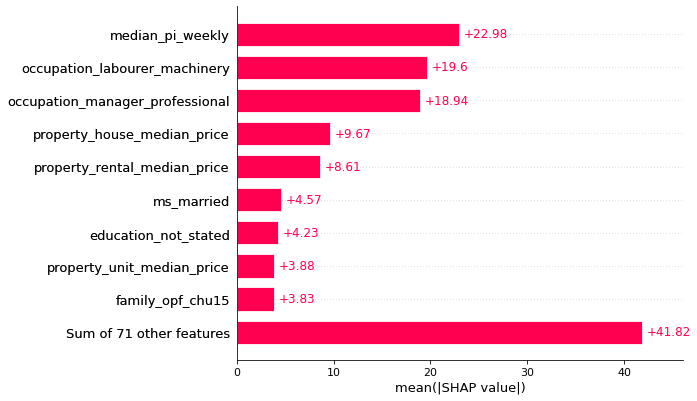

In [146]:
# Plot bar plot of absolute feature importance (bascially a feature importance plot)
shap.plots.bar(tmpcomb, 10)

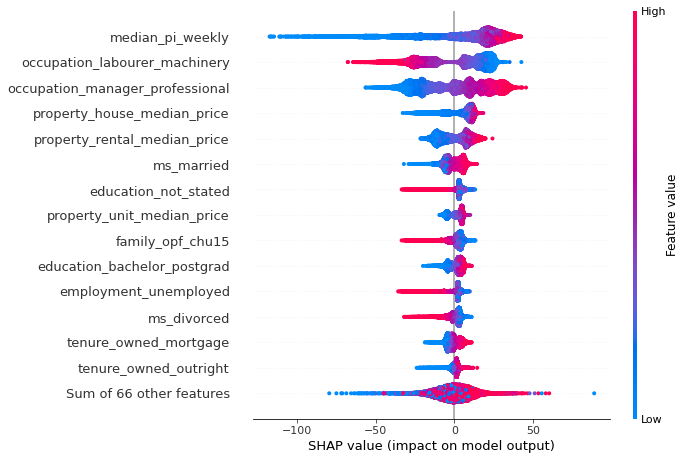

In [147]:
# Plot SHAP value magnitudes over all samples, and show the distribution of the impacts of each feature on the model output
shap.plots.beeswarm(tmpcomb, 15)

## 4.3 Examine SEIFA scores of particular gentrification/filtering hotspots

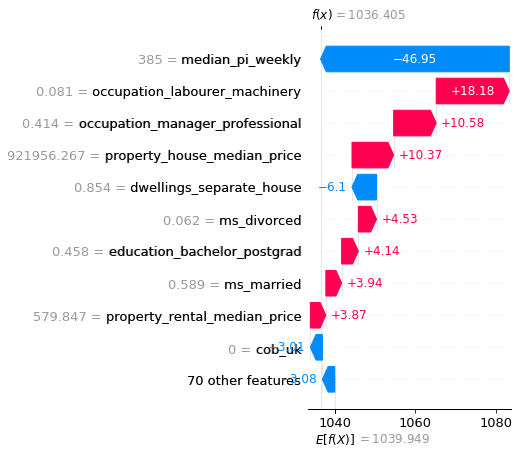

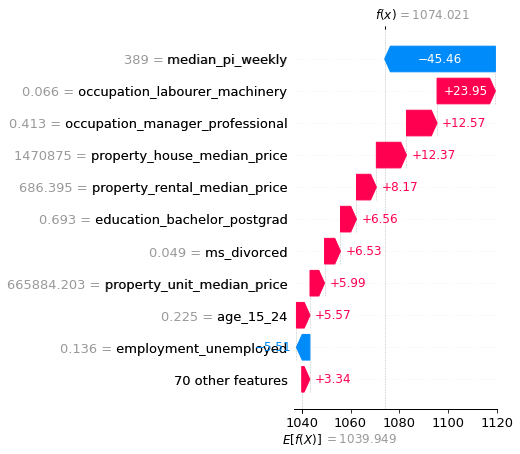

In [171]:
# Test Gentrifying SA1 area in Eastwood - 12602149718 - Predicting 2016 index
plt.figure(figsize=(10, 10))
plt.subplot(1,2,1)
shap.plots.waterfall(tmpcomb[8990],11)

plt.subplot(1,2,2)
shap.plots.waterfall(tmpcomb[19617],11)


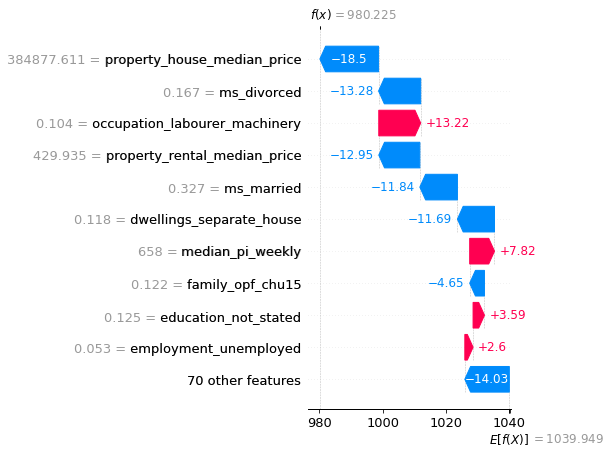

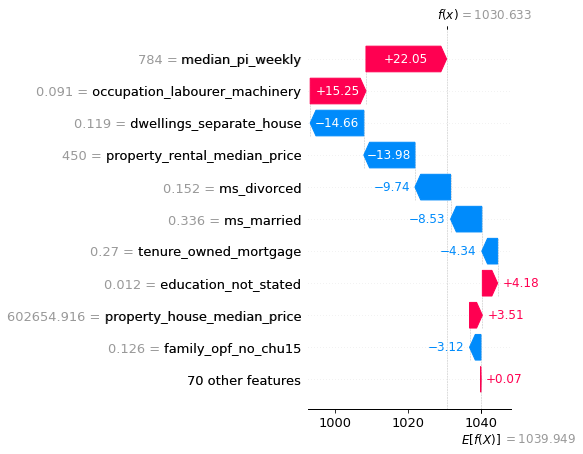

<Figure size 432x288 with 0 Axes>

In [156]:
# Test Gentrifying SA1 area in Sutherland - 12802153837 - Predicting 2016 index
plt.figure(figsize=(2, 2))
plt.subplot(1,2,1)
shap.plots.waterfall(tmpcomb[10529],11)

plt.subplot(1,2,2)
shap.plots.waterfall(tmpcomb[21161],11)

plt.subplots_adjust(wspace=4)
plt.show()

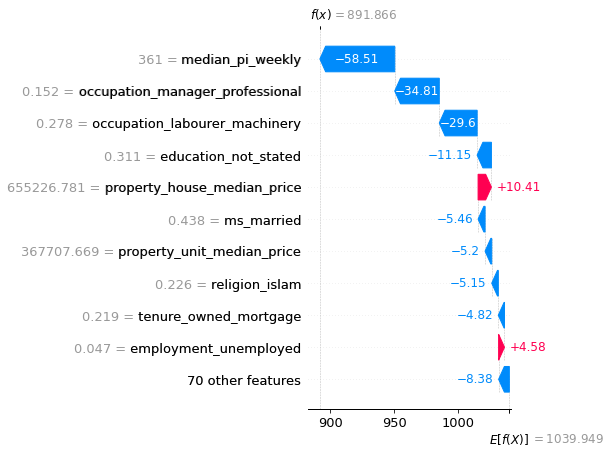

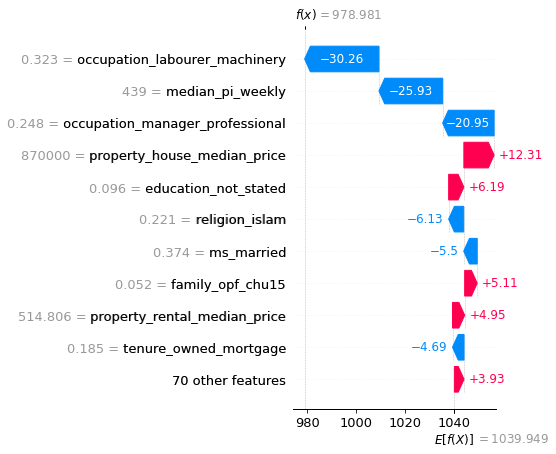

<Figure size 432x288 with 0 Axes>

In [11]:
# Test Gentrifying SA1 area in Auburn - 12501158230 - Predicting 2016 index
plt.figure(figsize=(2, 2))
plt.subplot(1,2,1)
shap.plots.waterfall(tmpcomb[8004],11)

plt.subplot(1,2,2)
shap.plots.waterfall(tmpcomb[18631],11)

plt.subplots_adjust(wspace=4)
plt.show()

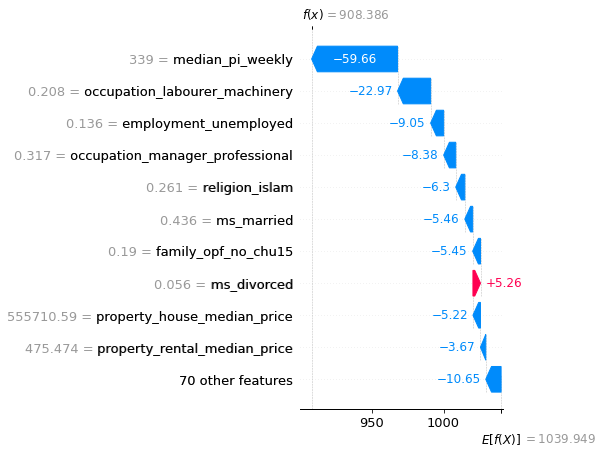

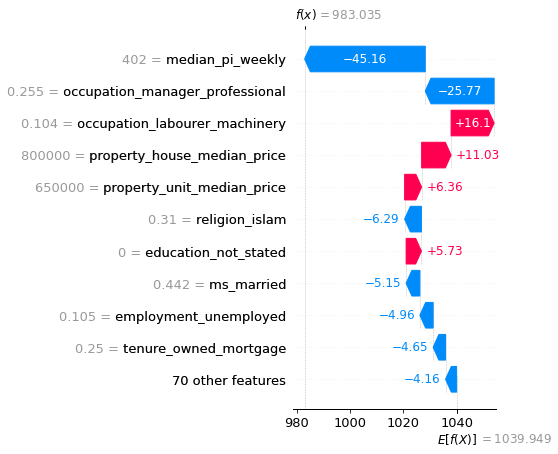

<Figure size 432x288 with 0 Axes>

In [14]:
# Test Gentrifying SA1 area in Bankstown - 11901135408 - Predicting 2016 index
plt.figure(figsize=(2, 2))
plt.subplot(1,2,1)
shap.plots.waterfall(tmpcomb[3271],11)

plt.subplot(1,2,2)
shap.plots.waterfall(tmpcomb[13889],11)

plt.subplots_adjust(wspace=4)
plt.show()

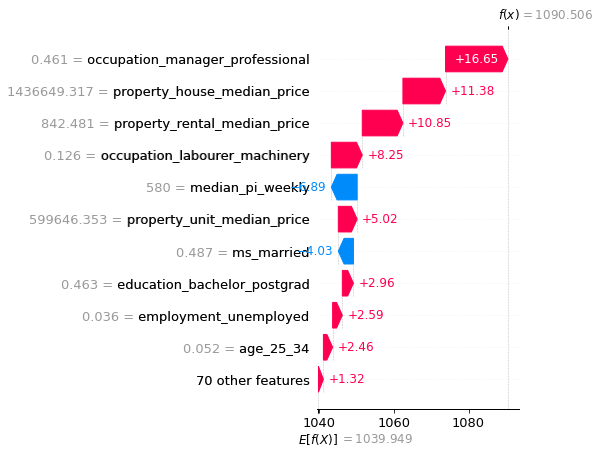

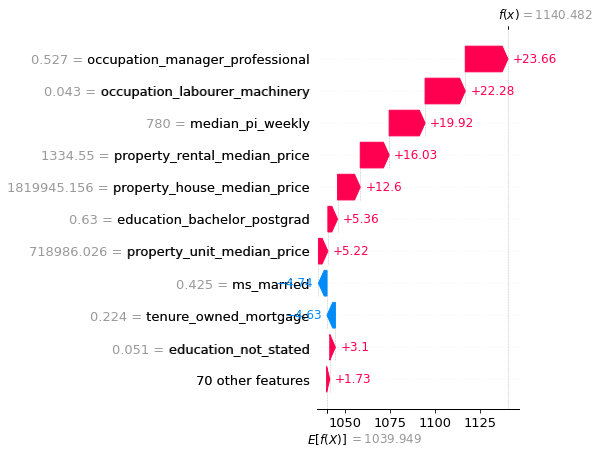

<Figure size 432x288 with 0 Axes>

In [13]:
# Test Gentrifying SA1 area in Maroubra - 11802156612 - Predicting 2016 index
plt.figure(figsize=(2, 2))
plt.subplot(1,2,1)
shap.plots.waterfall(tmpcomb[3142],11)

plt.subplot(1,2,2)
shap.plots.waterfall(tmpcomb[13760],11)

plt.subplots_adjust(wspace=4)
plt.show()

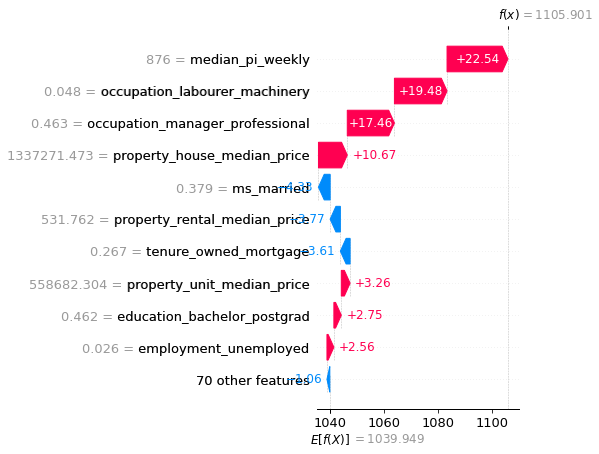

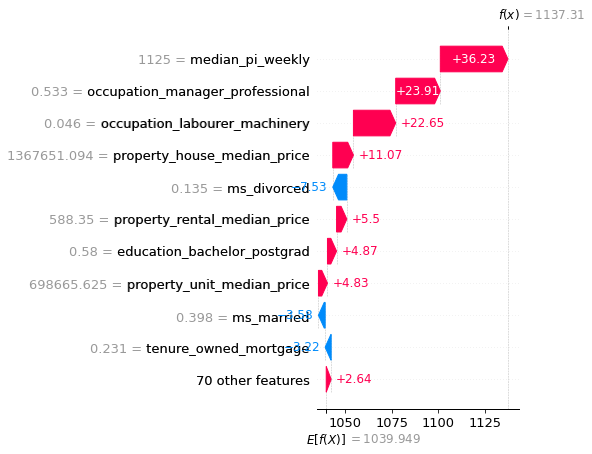

<Figure size 432x288 with 0 Axes>

In [15]:
# Test Gentrifying SA1 area in Brookvale - 12203142913 - Predicting 2016 index
plt.figure(figsize=(2, 2))
plt.subplot(1,2,1)
shap.plots.waterfall(tmpcomb[6514],11)

plt.subplot(1,2,2)
shap.plots.waterfall(tmpcomb[17142],11)

plt.subplots_adjust(wspace=4)
plt.show()

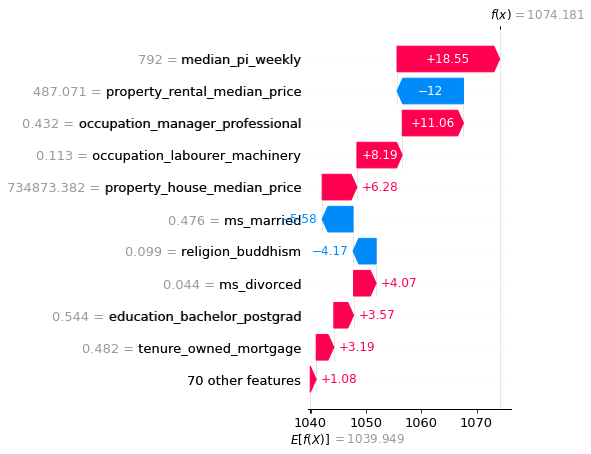

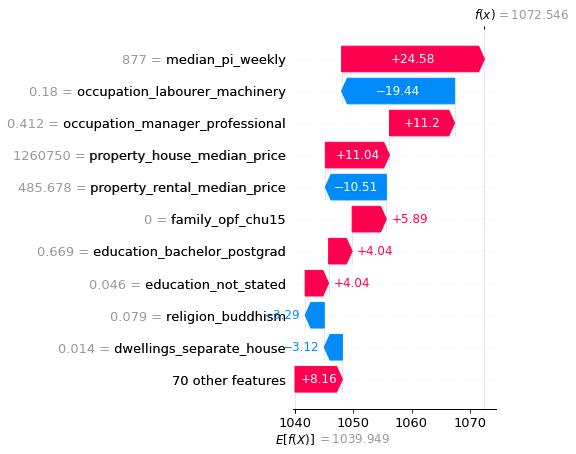

<Figure size 432x288 with 0 Axes>

In [18]:
# Test Gentrifying SA1 area in Summer Hill - 12003139633 - Predicting 2016 index
plt.figure(figsize=(2, 2))
plt.subplot(1,2,1)
shap.plots.waterfall(tmpcomb[5082],11)

plt.subplot(1,2,2)
shap.plots.waterfall(tmpcomb[15707],11)

plt.subplots_adjust(wspace=4)
plt.show()

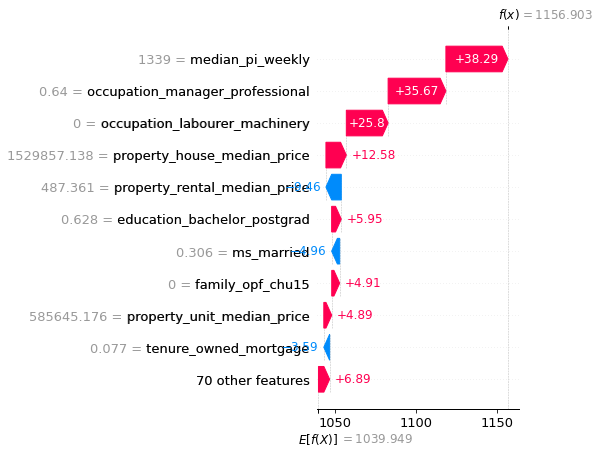

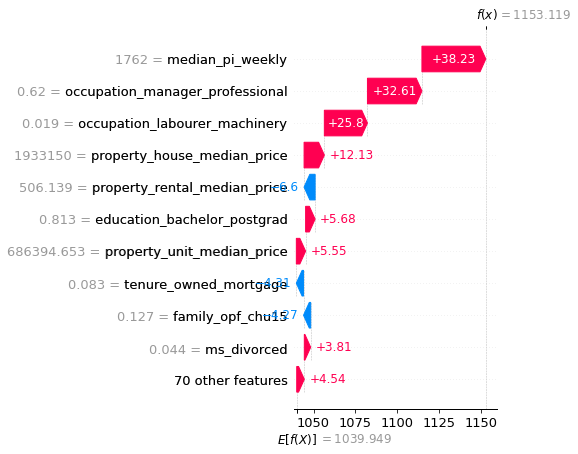

<Figure size 432x288 with 0 Axes>

In [19]:
# Test Gentrifying SA1 area in North Sydney - 12104141713 - Predicting 2016 index
plt.figure(figsize=(2, 2))
plt.subplot(1,2,1)
shap.plots.waterfall(tmpcomb[6054],11)

plt.subplot(1,2,2)
shap.plots.waterfall(tmpcomb[16680],11)

plt.subplots_adjust(wspace=4)
plt.show()

# 5. Use tuned model to predict 2021 Gentrification locations

## 5.1 Define 'x' dataset for 2016, predict 2021 SEIFA scores

In [31]:
# Define 'x' data
X_16 = data_16.iloc[:,2:-13]

# Define new dataset to store results in:
data_16_gbm = data_16

# Fit model to 2016 input data to predict 2021 SEIFA scores
data_16_gbm['Predicted_SEIFA_21'] = gbm_tuned_model.predict(X_16)

# Export GBM predicted SEIFA 2021 Values
data_16_gbm.to_csv('C:\\Users\\wthac\\Desktop\\Value Australia\\Data\\ML Gentrification Prediction\\Outputs/GBM_Predicted_2016_21.csv')

## 5.2 Calculate change in rank for each SA1 area: 2016 - 2021

In [32]:
# Calculate the rank of each irsad_score within year
seq_16 = sorted(data_16_gbm['irsad_score'])
index_16 = [seq_16.index(v) for v in data_16_gbm['irsad_score']]

seq_21 = sorted(data_16_gbm['Predicted_SEIFA_21'])
index_21 = [seq_21.index(v) for v in data_16_gbm['Predicted_SEIFA_21']]

# Merge rank back onto main dataset
data_16_gbm['SEIFA_rank_16'] = index_16
data_16_gbm['SEIFA_rank_21'] = index_21

# Calculate change in rank:
data_16_gbm['SEIFA_rank_change'] = data_16_gbm['SEIFA_rank_21'] - data_16_gbm['SEIFA_rank_16']


## Calculate standard deviation of rank change
# Standard Deviation:
sd_rc = statistics.stdev(data_16_gbm['SEIFA_rank_change'])

# Bin data into SD rank change:
data_16_gbm['SEIFA_bins'] = pd.cut(x=data_16_gbm['SEIFA_rank_change'], \
                                   bins=[-10*sd_rc,-4*sd_rc, -2*sd_rc, -sd_thresh*sd_rc, sd_thresh*sd_rc, 2*sd_rc, 4*sd_rc, 10*sd_rc],\
                                   labels = ['< -4', '-4 - -2', '-2 - -1', '-1 - 1', '1 - 2', '2 - 4', '> 4'])

# Create subset of observations within +/- 1 SD for visualisation:
data_16_gbm_sd1 = data_16_gbm.loc[(data_16_gbm['SEIFA_rank_change'] < sd_thresh*sd_rc) & \
                                (data_16_gbm['SEIFA_rank_change'] > (-sd_thresh*sd_rc) ) ]

# Export data_16_gbm to look at dataset
data_16_gbm.to_csv("C:\\Users\\wthac\\Desktop\\Value Australia\\Data\\ML Gentrification Prediction\\Outputs/data_16_gbm_predictions.csv")

## 5.3 Define gentrification flag for 2011 - 2016

In [33]:
# Create dataset to store results
data_11_gbm = data_11

# Calculate the rank of each irsad_score within year
seq_11 = sorted(data_11_gbm['irsad_score_11'])
index_11 = [seq_11.index(v) for v in data_11_gbm['irsad_score_11']]

seq_16 = sorted(data_11_gbm['irsad_score_16'])
index_16 = [seq_16.index(v) for v in data_11_gbm['irsad_score_16']]

# Merge rank back onto main dataset
data_11_gbm['SEIFA_rank_11'] = index_11
data_11_gbm['SEIFA_rank_16'] = index_16

# Calculate change in rank:
data_11_gbm['SEIFA_rank_change_1116'] = data_11_gbm['SEIFA_rank_16'] - data_11_gbm['SEIFA_rank_11']


## Calculate standard deviation of rank change
# Standard Deviation:
sd_rc = statistics.stdev(data_11_gbm['SEIFA_rank_change_1116'])

# Bin data into SD rank change:
data_11_gbm['SEIFA_bins'] = pd.cut(x=data_11_gbm['SEIFA_rank_change_1116'], \
                                   bins=[-10*sd_rc,-4*sd_rc, -2*sd_rc, -sd_thresh*sd_rc, sd_thresh*sd_rc, 2*sd_rc, 4*sd_rc, 10*sd_rc],\
                                   labels = ['< -4', '-4 - -2', '-2 - -1', '-1 - 1', '1 - 2', '2 - 4', '> 4'])

# Create subset of observations within +/- 1 SD for visualisation:
data_11_gbm_sd1 = data_11_gbm.loc[(data_11_gbm['SEIFA_rank_change_1116'] < sd_thresh*sd_rc) & \
                                (data_11_gbm['SEIFA_rank_change_1116'] > (-sd_thresh*sd_rc) ) ]

## 5.4 Get Sydney subset for cleaner visualisation

### 5.4.1 Import Statistical Area Boundaries

In [34]:
# Import sa1 boundaries
with zipfile.ZipFile("C:\\Users\\wthac\\Desktop\\Value Australia\\Data\\All Projects\\SA Boundaries/1270055001_sa1_2016_aust_shape.zip","r") as zip_ref:
    zip_ref.extractall("C:\\Users\\wthac\\Desktop\\Value Australia\\Data\\All Projects\\SA Boundaries")
    
gdf_sa1 = gpd.read_file("C:\\Users\\wthac\\Desktop\\Value Australia\\Data\\All Projects\\SA Boundaries/SA1_2016_AUST.shp")

gdf_sa1.SA1_MAIN16 = gdf_sa1.SA1_MAIN16.astype("int64")


# Import sa2 boundaries
with zipfile.ZipFile("C:\\Users\\wthac\\Desktop\\Value Australia\\Data\\All Projects\\SA Boundaries/1270055001_sa2_2016_aust_shape.zip","r") as zip_ref:
    zip_ref.extractall("C:\\Users\\wthac\\Desktop\\Value Australia\\Data\\All Projects\\SA Boundaries")
    
gdf_sa2 = gpd.read_file("C:\\Users\\wthac\\Desktop\\Value Australia\\Data\\All Projects\\SA Boundaries/SA2_2016_AUST.shp")

gdf_sa2.SA1_MAIN16 = gdf_sa2.SA2_MAIN16.astype("int64")


# Import sa3 boundaries
with zipfile.ZipFile("C:\\Users\\wthac\\Desktop\\Value Australia\\Data\\All Projects\\SA Boundaries/1270055001_sa3_2016_aust_shape.zip","r") as zip_ref:
    zip_ref.extractall("C:\\Users\\wthac\\Desktop\\Value Australia\\Data\\All Projects\\SA Boundaries")
    
gdf_sa3 = gpd.read_file("C:\\Users\\wthac\\Desktop\\Value Australia\\Data\\All Projects\\SA Boundaries/SA3_2016_AUST.shp")

gdf_sa3.SA3_NAME16 = gdf_sa3.SA3_NAME16.astype("str")

### 5.4.2 Define Sydney subset

In [35]:
# Define Sydney Sydney Subset
sa3_syd = ["Eastern Suburbs - North", "Eastern Suburbs - South",
           "Botany", "Sydney Inner City", "Marrickville - Sydenham - Petersham",
           "Leichhardt", "Kogarah - Rockdale", "Canterbury",
           "Hurstville", "Strathfield - Burwood - Ashfield","Canada Bay",
           "Bankstown", "Auburn", "Merrylands - Guildford", "Cronulla - Miranda - Caringbah",
           "Sutherland - Menai - Heathcote", "Campbelltown (NSW)", "Liverpool", "Faigbmield",
           "Parramatta", "Blacktown", "Mount Druitt", "Blacktown - North",
           "Baulkham Hills", "Carlingford", "Ryde - Hunters Hill", "North Sydney - Mosman",
           "Chatswood - Lane Cove", "Manly", "Ku-ring-gai", "Warringah",
           "Warringah", "Hornsby", "Dural - Wisemans Ferry", "Pittwater", "Rouse Hill - McGraths Hill",
           "Campbelltown (NSW)", "Camden", "Bringelly - Green Valley", "Penrith",
           "St Marys", "Richmond - Windsor", "Pennant Hills - Epping", "Fairfield"]

subset_syd = gdf_sa1[gdf_sa1.SA3_NAME16.isin(sa3_syd)]

# Get unique SA1_Codes 
mylist_syd = list(set(subset_syd.SA1_MAIN16))


# Subset to sydney datasets
gdf_sa3_syd = gdf_sa3[gdf_sa3.SA3_NAME16.isin(sa3_syd)]


# Subset SEIFA dataset to Sydney
data_16_gbm_syd = data_16_gbm[data_16_gbm.SA1_MAIN16.isin(mylist_syd)]
data_16_gbm_syd_sd1 = data_16_gbm_sd1[data_16_gbm_sd1.SA1_MAIN16.isin(mylist_syd)]

data_11_gbm_syd = data_11_gbm[data_11_gbm.SA1_MAIN16.isin(mylist_syd)]
data_11_gbm_syd_sd1 = data_11_gbm_sd1[data_11_gbm_sd1.SA1_MAIN16.isin(mylist_syd)]

## 5.5 Visualise gentrification hotspots for two study periods

In [36]:
# Merge shapefile to data frame
sa1_gbm_syd_16 = gdf_sa1.merge(data_16_gbm_syd, on = "SA1_MAIN16")
sa1_gbm_syd_sd1_16 = gdf_sa1.merge(data_16_gbm_syd_sd1, on = "SA1_MAIN16")

sa1_gbm_syd_11 = gdf_sa1.merge(data_11_gbm_syd, on = "SA1_MAIN16")
sa1_gbm_syd_sd1_11 = gdf_sa1.merge(data_11_gbm_syd_sd1, on = "SA1_MAIN16")

### 5.5.1 Visualise ACTUAL Gentrification between 2011 - 2016

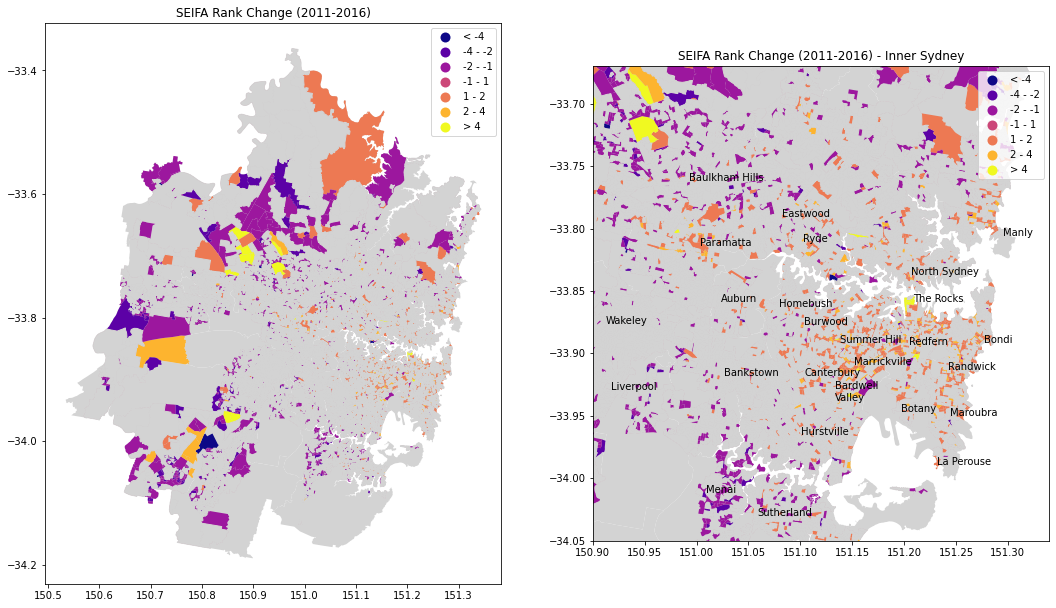

In [37]:
# Visualise SIEFA Rank Change coverage
figure, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 12))

gdf_sa3_syd.plot(color='lightgrey', ax=axes[0])
sa1_gbm_syd_11.plot(column='SEIFA_bins', cmap="plasma", ax=axes[0], legend=True)
sa1_gbm_syd_sd1_11.plot(color='lightgrey', edgecolor='lightgrey', ax=axes[0])
ax=axes[0].set(title='SEIFA Rank Change (2011-2016)')

gdf_sa3_syd.plot(color='lightgrey', ax=axes[1])
sa1_gbm_syd_11.plot(column='SEIFA_bins', cmap="plasma", ax=axes[1], legend=True)
sa1_gbm_syd_sd1_11.plot(color='lightgrey', edgecolor='lightgrey', ax=axes[1])
ax=axes[1].set(title='SEIFA Rank Change (2011-2016) - Inner Sydney')
ax=axes[1].set_xlim([150.9, 151.34])
ax=axes[1].set_ylim([-34.05, -33.67])
ax=axes[1].text(151.152, -33.909, 'Marrickville'); ax=axes[1].text(151.277, -33.892, 'Bondi'); 
ax=axes[1].text(151.295, -33.806, 'Manly'); ax=axes[1].text(151.197, -33.947, 'Botany'); 
ax=axes[1].text(151.205, -33.893, 'Redfern'); ax=axes[1].text(151.133, -33.938, 'Bardwell\nValley');
ax=axes[1].text(151.104, -33.918, 'Canterbury'); ax=axes[1].text(151.103, -33.811, 'Ryde'); 
ax=axes[1].text(151.232, -33.989, 'La Perouse'); ax=axes[1].text(151.244, -33.950, 'Maroubra'); 
ax=axes[1].text(151.003, -33.814, 'Paramatta'); ax=axes[1].text(151.138, -33.892, 'Summer Hill'); 
ax=axes[1].text(151.059, -34.030, 'Sutherland'); ax=axes[1].text(151.101, -33.965, 'Hurstville'); 
ax=axes[1].text(150.918, -33.929, 'Liverpool'); ax=axes[1].text(151.207, -33.837, 'North Sydney'); 
ax=axes[1].text(151.009, -34.012, 'Menai'); ax=axes[1].text(150.993, -33.762, 'Baulkham Hills'); 
ax=axes[1].text(151.209, -33.859, 'The Rocks'); ax=axes[1].text(151.242, -33.913, 'Randwick');

ax=axes[1].text(151.026, -33.918, 'Bankstown'); ax=axes[1].text(151.0236, -33.859, 'Auburn');
ax=axes[1].text(151.082, -33.7904, 'Eastwood'); ax=axes[1].text(151.0796, -33.863, 'Homebush');
ax=axes[1].text(150.912, -33.876, 'Wakeley'); ax=axes[1].text(151.104, -33.877, 'Burwood');

### 5.5.2 Visualise PREDICTED Gentrification between 2016 - 2021

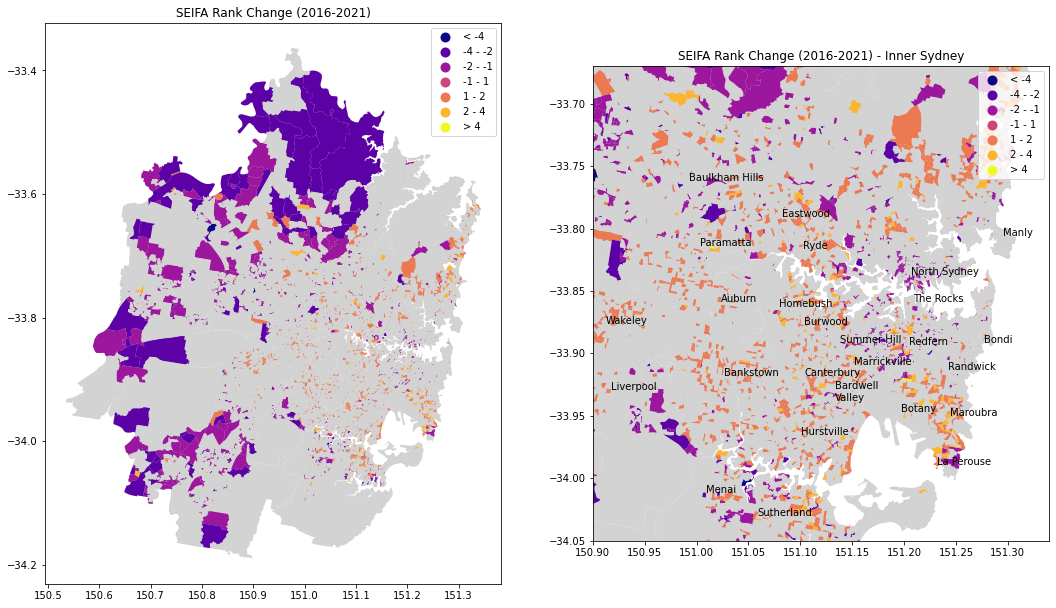

In [38]:
# Visualise SIEFA Rank Change coverage
figure, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 12))

gdf_sa3_syd.plot(color='lightgrey', ax=axes[0])
sa1_gbm_syd_16.plot(column='SEIFA_bins', cmap="plasma", ax=axes[0], legend=True)
sa1_gbm_syd_sd1_16.plot(color='lightgrey', edgecolor='lightgrey', ax=axes[0])
ax=axes[0].set(title='SEIFA Rank Change (2016-2021)')

gdf_sa3_syd.plot(color='lightgrey', ax=axes[1])
sa1_gbm_syd_16.plot(column='SEIFA_bins', cmap="plasma", ax=axes[1], legend=True)
sa1_gbm_syd_sd1_16.plot(color='lightgrey', edgecolor='lightgrey', ax=axes[1])
#gdf_sa2.plot(color='lightgrey', edgecolor = 'black', ax=axes[1], alpha=0.2)
ax=axes[1].set(title='SEIFA Rank Change (2016-2021) - Inner Sydney')
ax=axes[1].set_xlim([150.9, 151.34])
ax=axes[1].set_ylim([-34.05, -33.67])
ax=axes[1].text(151.152, -33.909, 'Marrickville'); ax=axes[1].text(151.277, -33.892, 'Bondi'); 
ax=axes[1].text(151.295, -33.806, 'Manly'); ax=axes[1].text(151.197, -33.947, 'Botany'); 
ax=axes[1].text(151.205, -33.893, 'Redfern'); ax=axes[1].text(151.133, -33.938, 'Bardwell\nValley');
ax=axes[1].text(151.104, -33.918, 'Canterbury'); ax=axes[1].text(151.103, -33.816, 'Ryde'); 
ax=axes[1].text(151.232, -33.989, 'La Perouse'); ax=axes[1].text(151.244, -33.950, 'Maroubra'); 
ax=axes[1].text(151.003, -33.814, 'Paramatta'); ax=axes[1].text(151.138, -33.892, 'Summer Hill'); 
ax=axes[1].text(151.059, -34.030, 'Sutherland'); ax=axes[1].text(151.101, -33.965, 'Hurstville'); 
ax=axes[1].text(150.918, -33.929, 'Liverpool'); ax=axes[1].text(151.207, -33.837, 'North Sydney'); 
ax=axes[1].text(151.009, -34.012, 'Menai'); ax=axes[1].text(150.993, -33.762, 'Baulkham Hills'); 
ax=axes[1].text(151.209, -33.859, 'The Rocks'); ax=axes[1].text(151.242, -33.913, 'Randwick');

ax=axes[1].text(151.026, -33.918, 'Bankstown'); ax=axes[1].text(151.0236, -33.859, 'Auburn');
ax=axes[1].text(151.082, -33.7904, 'Eastwood'); ax=axes[1].text(151.0796, -33.863, 'Homebush');
ax=axes[1].text(150.912, -33.876, 'Wakeley'); ax=axes[1].text(151.104, -33.877, 'Burwood');